In [82]:
%pylab inline 
        
##be careful, lamda is a rate, eta is a probability!
#lamda is (l1=rate of interaction Y+X->Y+Y)+(l2=rate of Y+X->Y+Z), so lamda=l1+l2, eta=l1/l1+l2
lamda=1; eta=.95; #5% of discovering yourself immune

##beta=rate Z+X->Y+X, gamma=rate Z->X
beta=.0; gamma=.05 #no immune->ill, loss of immunity in 5%

##d1 Y->X,d2 Y->Z, alpha: Y+(not X)-> Z+(not X)
d1=d2=.01 ; alpha=0.  #1% of probability of losing the illness, no gaining immunity through contact between Y

#[50,200,500,2000]
tot=2000 #number of nodes
houses=5
house_size=tot//houses  #[5,50,100] households
medians=[(house_size//2)+house_size*i for i in range(0,tot//house_size)]

init_spread=0.01 #initial spreaders percentage
#print(medians)

T=100
t=0
max_it=15000

Populating the interactive namespace from numpy and matplotlib


/home/simone/anaconda3/envs/python_env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['beta', 'gamma']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [83]:
def delta(status,desired): #returns 0 if and only if status and desired are the same
    return int(status==desired)

In [84]:
class Node:
    def __init__(self, status):
        self.stat=status #status of the node:0=X,1=Y,2=Z
        self.neig=[]
        self.k=0
        self.kx=0
        self.omega=0 #total rate of transition of the node
        self.spontaneous=0  #rate of spontaneous transistion of the node
        
    def insert_neighbours(self,neigh):
        self.neig=neigh #list of neighbours
        self.k=size(neigh)
        
    def update(self, increment=0):
        self.kx+= increment 
        self.omega=self.myomega()
        self.spontaneous=self.spont()
    
    def myomega(self): #not normalized probability of being chosen,proportional to transition rate
        return delta(self.stat,1)*(self.kx*lamda+alpha*(self.k-self.kx)+d1+d2)+delta(self.stat,2)*(gamma+self.kx*beta)
    
    def spont(self): #rate of spontanous transitions
        return delta(self.stat,1)*(d1+d2)+delta(self.stat,2)*gamma

In [85]:
node=[]
for i in range(tot):
    r= 1 if np.random.rand(1)<init_spread else 0
    node.append(Node(r))
    
for i in range(tot):  #insert neighbours and fix k
    node[i].insert_neighbours(  [j for j in range(    house_size*(i//house_size),house_size*(1+i//house_size)) if j!=i]
                              + [m for m in medians if (i in medians)and(m!=i)])
    
for i in range(tot): #fix kx,omega, spontaneous rate
    node[i].update(size([node[j] for j in node[i].neig if node[j].stat==0]))
    
#print([i for i in range(tot) if node[i].stat==1])
#print([node[i].kx for i in range(tot)])
W=sum([node[i].omega for i in range(tot)])
W
Nx=sum([node[i].stat==0 for i in range(tot)])
Ny=sum([node[i].stat==1 for i in range(tot)])
print(Nx,Ny)

1981 19


## SIMULATOR, Improved Rejection sampling with node-based method

In [86]:
#this function choose a node randomly and accepts it with probability proportional to its total rate (omega[i])
def choose_node():
    while(True):
        r2,i= np.random.rand(2)
        i=int(i*tot) #extracted node
        if(node[i].omega>r2*W):
            return i
        
        
##choose noded version2:
def choose_node_2(probs):
    sorted_probs= sorted(((v, i) for i, v in enumerate(probs)), reverse=True)

    cumulates = np.cumsum([item[0] for item in sorted_probs])  
    r2=np.random.rand()

    for i, val in enumerate(cumulates):
        if r2 < val:
            idx=sorted_probs[i][1]
            return idx       

        
#this function represent a spontaneous process (nodes not interacting)
def spontaneous_transition(i):
    global Nx,Ny
    if(node[i].stat==0):
        print("Should not happen")
        return
    r=np.random.rand()
    if((node[i].stat==1)and(r*(d1+d2)<d1)):  #case Y=>X with rate d1
        #print("Y to X")
        node[i].stat=0
        node[i].update(0)
        Nx+=1
        Ny-=1
        for n in node[i].neig:
            node[n].update(1) #all neighbours have 1 more X neighbours
        return
    elif((node[i].stat==1)and(r*(d1+d2)>d1)): #case Y=>Z rate d2
        #print("Y to Z")
        node[i].stat=2   #does not change kx of neighbours, so they do not need to be updated
        node[i].update(0)
        Ny-=1
        return
    #case Z=>X
    #print("Z to X")
    node[i].stat=0
    node[i].update(0)
    Nx+=1
    for n in node[i].neig:
        node[n].update(1)
    return
    
    
#this function simulate contact from node[i] to one of its neighbours  
def make_contact_from(i):
    global Nx,Ny
    #n=random.choice(node[i].neig)

    s=node[i].stat

    #choose node according to its interaction rate: i//2 is 0 for Y, 1 for Z, no X enters here
            #i==Z,only interacts with X    #i=Y, interacts with X with rate lamda, otherwise alpha
    
    #probs=[(s//2)*beta*delta(node[j].stat,0)+   (1-s//2)*(delta(node[j].stat,0)*lamda+(1-delta(node[j].stat,0))*alpha) for j in node[i].neig]
    
    
            #I'm Z and neighbours is X        I'm Y      neig=X                      neig not X
    probs=[(s//2)*beta*int(not node[j].stat) +(1-s//2)*(lamda*int(not node[j].stat)+(1-int(not node[j].stat))*alpha) for j in node[i].neig]
    probs=probs/sum(probs)
    
    #choose_node2 will gives index referred to node[i].neig, so
    q=choose_node_2(probs)
    
    if(q==None):
        print("problems from node "+str(i)+":",node[i].stat,node[i].omega,node[i].spontaneous)
    n=node[i].neig[q]
    
    
    if((node[i].stat==1)and(node[n].stat==0)): #Y+X 
        if(np.random.rand()<eta):  #Y+X=> Y+Y with prob eta           
            node[n].stat=1
            node[n].update(0)
            Nx-=1
            Ny+=1
            for nn in node[n].neig:
                node[nn].update(-1) #all the neighbours of node[n] have 1 less X neighbour, me included
            return
        else:  #Y+X=>Y+Z with (1-eta)
            #print(str(i)+"+X->Y+Z")
            node[n].stat=2
            node[n].update(0)
            Nx-=1
            for nn in node[n].neig:
                node[nn].update(-1) #all the neighbours of node[n] have 1 less X neighbour, me included
            return
    elif(node[i].stat==1): #Y+ (Z or Y) => Z+ (Z or Y)        
        node[i].stat=2
        Ny-=1
        node[i].update(0)   #No change in kx for me nor my neighbours
        return
    #if u arrive here, it means u are Z && kx!=0, so u can do contact transition of Z
    #Z+X->Y+X
    if(node[i].stat!=2):
        print("cosa che diamine")
    node[i].stat=1
    node[i].update(0)  #neighbours no need to update: kx is the same for them
    Ny+=1
    return

In [87]:
%%time 

results=[]
t=0
r=np.random.rand(2*max_it)
it=0

results.append((t,Nx,Ny,tot-(Nx+Ny)))

while((it<2*max_it)and (t<=T)):
    dt=-log(r[it])/W
    t+=dt
    i=choose_node_2([node[i].omega/W for i in range(tot)])
    
    #print('node chosen', i)
    if(i==None):
        print('end ',Nx,Ny,[node[j].kx for j in range(tot) if node[j].stat==1])
        break
    
    if(r[it+1]*node[i].omega>node[i].spontaneous): 
        make_contact_from(i)
    else:
        spontaneous_transition(i)

    W=sum([node[j].omega for j in range(tot)])
    results.append((t,Nx,Ny,tot-(Nx+Ny)))
    it+=2
    if(it/2>max_it-1):
        print('approaching max_it')
    if(T-t<0.01):
        print('approaching T')

approaching T
approaching T
CPU times: user 36.8 s, sys: 75.9 ms, total: 36.9 s
Wall time: 36.9 s


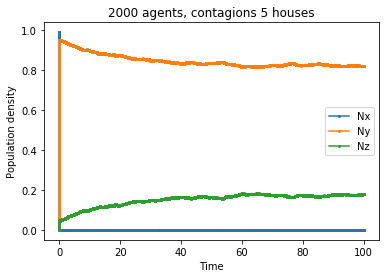

In [88]:
times= [item[0] for item in results]
Nx_plot= [item[1]/tot for item in results]
Ny_plot= [item[2]/tot for item in results]
Nz_plot= [item[3]/tot for item in results]

ax = subplot(111)

ax.plot(times,Nx_plot,'-o',label='Nx',markersize=2)
ax.plot(times,Ny_plot,'-o',label='Ny',markersize=2)
ax.plot(times,Nz_plot,'-o',label='Nz',markersize=2)
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Population density')
plt.title(str(tot)+' agents, contagions '+str(houses)+' houses')
#plt.savefig('Y_contagion_'+str(tot)+'_complete_graph_myinfection.png',dpi=200)
plt.show()

In [ ]:
# uniform neighbour: 500: 1.69, 1000: 7.7, 2000:27.8s 
#rate based neighbour v1 500:6 ,1000:21 ,2000:91 s
#rate based neighbour v2 500:5.75 ,1000:21.5 ,2000:86 s

## LIMITATIONS OF NODE BASED METHOD for multiple transitions, with uniform neighbour distribution

Be aware that for how the problem is stated, the rates are used only to sample the transition, so even if I put 

lamda=1; eta=1. so Y for sure infects a neighbour X to Y

beta=rate Z+X->Y+X, gamma=rate Z->X
beta=.0; gamma=.0 

##d1 Y->X,d2 Y->Z, alpha: Y+(not X)-> Z+(not X)
d1=d2=.0 ; alpha=0

U expect to only allow Y+X->Y+Y, so Y should never die
Actually what happens is that at the end u have 20% X, 0% Y and 80% Z.
Why? Y has spontaneous rate=0 so it always makes contact, but inside it doesn't matter the rate, it just sees who the extracted neighbour is. So Whenever two Y see each other, one becomes Z. In this model Z will never actually die because it has no transition: omega_Z=spontaneous_Z=0, so at the end Z are the majority.
What happens with X and Y?
In this model it will always extract a Y node, the only with omega!=0, and always make contact.
If u find an X, it becomes an Y, otherwise u become a Z INDEPENDENTLY OF THE alpha RATE.
The simulation stops when no node is extracted, so no more Y.

In [ ]:
Nyy0=983
Nxx0=1017

print(it/2)
final_x=Nxx0*(1-1/(tot-1))**(it/2)
print(final_x/tot,Nx_plot[-1])

In [57]:
print([node[j].stat for j in range(tot)])


[1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
